# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [1]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_rna_expression_data,
                          load_seq_comparison_data)
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table

%matplotlib inline

y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
# m1h = load_m1h_activation_data()
#tfs, ptrs, = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
idents = load_seq_comparison_data()

#tfs = tfs.drop(columns=['tpm_stdev'])
#tfs = tfs.set_index(['gene', 'isoacc', 'tiss'])
#tfs = tfs.unstack(level='tiss')
#tfs.columns = tfs.columns.get_level_values(1)

#tfs.to_csv('tf_isoform_tissue_tpms.tsv', sep='\t')

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
ppi = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 
              ['category',
               'ad_clone_acc',
               'ad_gene_symbol',
               'db_gene_symbol',
               'score']].copy()
ppi = ppi.loc[ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                 ['score']
                 .transform(lambda row: (row == '1').any()),
              :]
ppi = ppi.loc[ppi.groupby('ad_clone_acc')
                  ['score']
                  .transform(lambda x: (x.isin(['0', '1']).any())),
              :]
ppi = ppi.loc[ppi.groupby('ad_gene_symbol')
                 ['ad_clone_acc']
                 .transform(lambda x: x.nunique() >= 2),
              :]
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
iso_pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                               y2h=ppi,
                                               y1h=y1h,
                                               m1h=m1h)

In [5]:
iso_pairs['pdi_n_max'] = iso_pairs['pdi_n_tested'] - (iso_pairs['pdi_n_min'] - iso_pairs['pdi_n_shared'])

In [8]:
iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(),
              ['tf_gene_symbol',
               'clone_acc_a',
               'clone_acc_b',
               'pdi_jaccard',
               'pdi_n_min',
               'pdi_n_max']].to_csv('/Users/lukelambourne/Desktop/PDI_isoform_pairs.tsv', sep='\t', index=False)

In [3]:
iso_pairs.shape

(806, 20)

In [6]:
(isoforms.groupby('gene').size() >= 2).sum()

249

In [4]:
iso_pairs.notnull().sum()

tf_gene_symbol            806
clone_acc_a               806
clone_acc_b               806
pair                      806
ppi_n_tested              321
ppi_n_shared              321
ppi_n_min                 321
ppi_n_min_diff            321
ppi_jaccard               321
ppi_simpson               167
ppi_n_diff                321
pdi_n_tested              117
pdi_n_shared              117
pdi_n_min                 117
pdi_n_min_diff            117
pdi_jaccard               117
pdi_simpson                65
pdi_n_diff                117
activation_fold_change    615
aa_seq_pct_id             806
dtype: int64

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


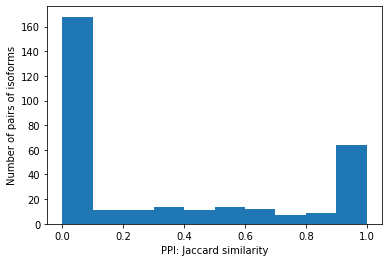

In [5]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['ppi_jaccard'], range=(0, 1), bins=10)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('PPI: Jaccard similarity')
plt.savefig('../../figures/ppi_jaccard_dist.pdf')

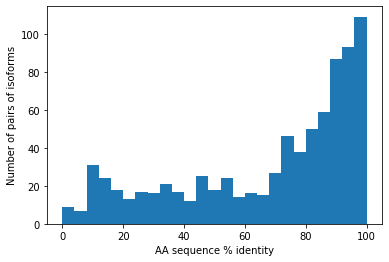

In [6]:
fig, ax = plt.subplots(1, 1)
ax.hist(iso_pairs['aa_seq_pct_id'], range=(0, 100), bins=25)
ax.set_ylabel('Number of pairs of isoforms')
ax.set_xlabel('AA sequence % identity')
plt.savefig('../../figures/aa_seq_pct_id_hist.pdf')

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


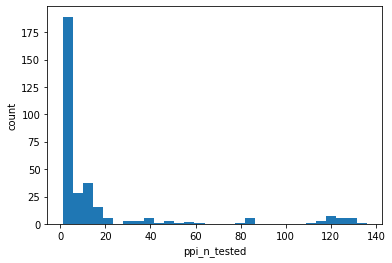

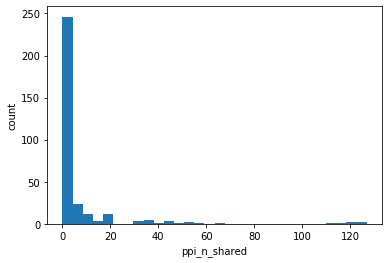

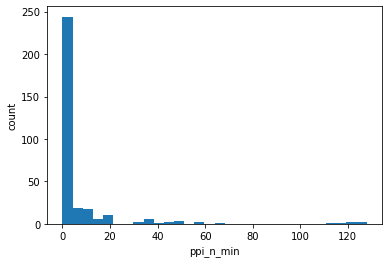

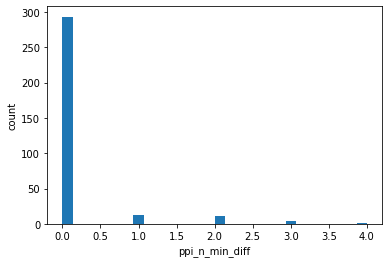

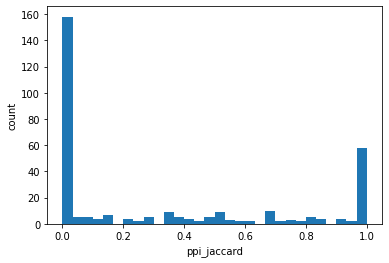

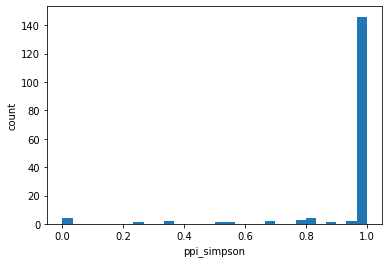

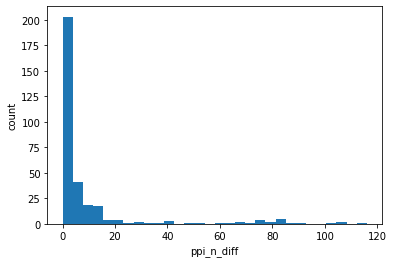

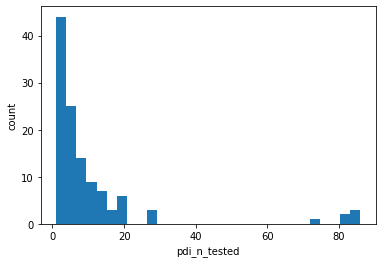

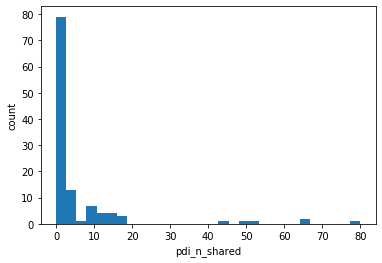

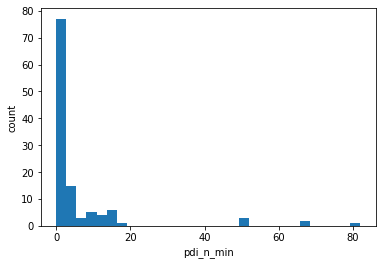

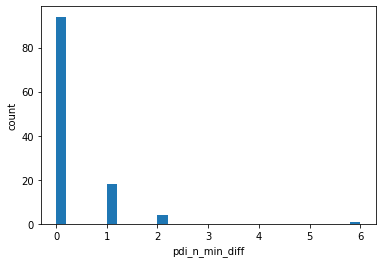

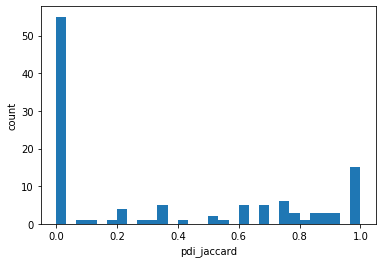

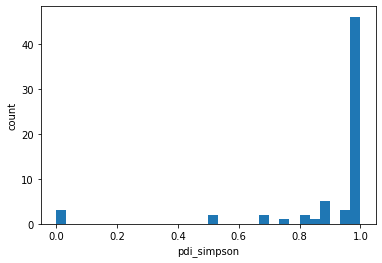

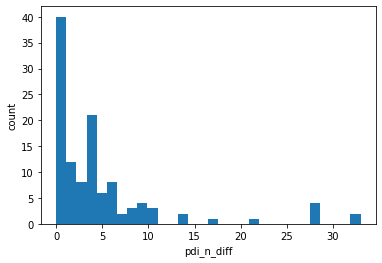

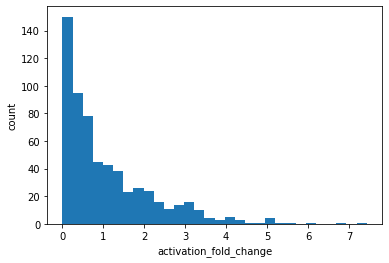

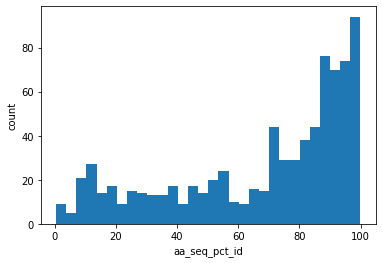

In [7]:
for col in iso_pairs.columns[4:]:
    plt.hist(iso_pairs[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()

In [8]:
iso_pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,AEBP2|2/3|05F03_AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535619,82.0
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,ARNT2|1/6|08C12_ARNT2|2/6|09E01,9.0,5.0,5.0,0.0,0.555556,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.094800,93.0
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,ARNT2|1/6|08C12_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,ARNT2|2/6|09E01_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,ARNTL|1/2|08H08_ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3


### Explore PDI/PPI profile differences and sequence similarity

Look into:
- PPI and PDI Jaccard distribution
  - Faceted by degree
- PPI versus PDI Jaccard/Simpson
  - Faceted by number of interactors
- PPI/PDI Jaccard versus sequence similarity

TODO
- Compare randomly selected isoforms from different genes (from paralog data)

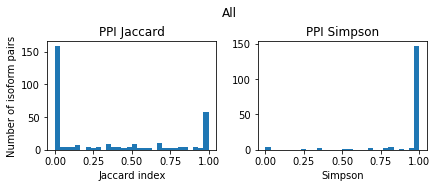

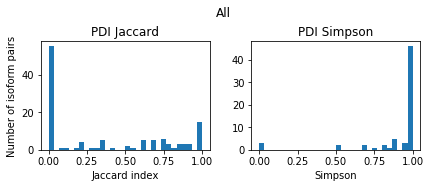

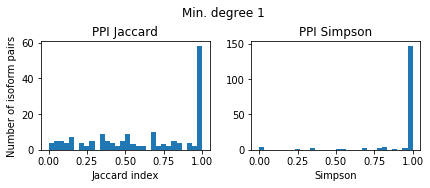

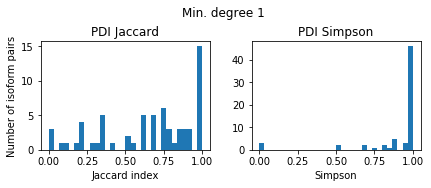

In [9]:
#  Jaccard/Simpson for PPI/PDI, histograms
def make_jaccard_simpson_hist(int_type, iso_pairs=iso_pairs, main_title='', nb=30):
    # int_type - ppi or pdi
    # nb - number of bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
    fig.suptitle(main_title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.87]) # adjust to allow for subtitle

    ax1.hist(iso_pairs[int_type + '_jaccard'], bins=nb)
    ax1.set_title(int_type.upper() + ' Jaccard')
    ax1.set_xlabel('Jaccard index')
    ax1.set_ylabel('Number of isoform pairs')
    
    ax2.hist(iso_pairs[int_type + '_simpson'], bins=nb)
    ax2.set_title(int_type.upper() + ' Simpson')
    ax2.set_xlabel('Simpson')
    
make_jaccard_simpson_hist('ppi', iso_pairs, 'All')
make_jaccard_simpson_hist('pdi', iso_pairs, 'All')
make_jaccard_simpson_hist('ppi', iso_pairs.loc[iso_pairs['ppi_n_min']>=1, :], main_title='Min. degree 1')
make_jaccard_simpson_hist('pdi', iso_pairs.loc[iso_pairs['pdi_n_min']>=1, :], main_title='Min. degree 1')


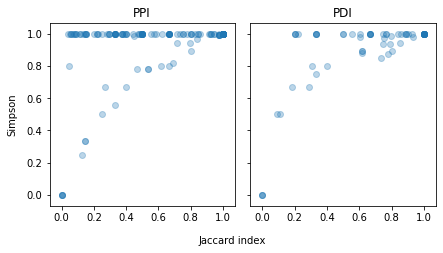

In [10]:
# Jaccard vs Simpson for PPI and PDI
def make_jaccard_simpson_plot(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

    alpha=0.3
    ax1.scatter(df.ppi_jaccard, df.ppi_simpson, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_aspect('equal')
    ax2.scatter(df.pdi_jaccard, df.pdi_simpson, alpha=alpha)
    ax2.set_title('PDI')
    ax2.set_aspect('equal')

    fig.tight_layout()
    fig.text(0.5, 0.05, 'Jaccard index', ha='center')
    fig.text(-0.02, 0.5, 'Simpson', va='center', rotation='vertical')

make_jaccard_simpson_plot(iso_pairs) # only plotted for cases  with 1+ interactions for both iso. of a pair

SpearmanrResult(correlation=nan, pvalue=nan)

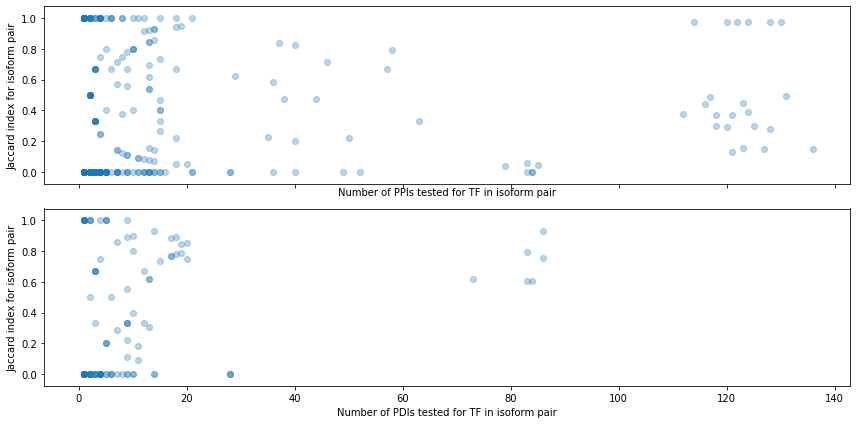

In [11]:
# Is there a relationship between degree and interaction profile similarity?
# For now use number of pdi/ppi tested as estimate of degree.
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(12,6))
alpha=0.3

ax1.scatter(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard, alpha=alpha)
ax1.set_xlabel('Number of PPIs tested for TF in isoform pair')
ax1.set_ylabel('Jaccard index for isoform pair')

ax2.scatter(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard, alpha=alpha)
ax2.set_xlabel('Number of PDIs tested for TF in isoform pair')
ax2.set_ylabel('Jaccard index for isoform pair')

fig.tight_layout()

# Luke question - how to determine if there is no bias between degree and Jaccard?
stats.spearmanr(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard)
stats.spearmanr(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard)

In [12]:
iso_pairs.sort_values(['ppi_jaccard', 'aa_seq_pct_id'], ascending=[True, False])

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
531,TFEC,TFEC|5/6|04A01,TFEC|6/6|03E11,TFEC|5/6|04A01_TFEC|6/6|03E11,3.0,0.0,0.0,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.5
374,RBPJ,RBPJ|2/4|07B11,RBPJ|3/4|07D11,RBPJ|2/4|07B11_RBPJ|3/4|07D11,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.707642,99.0
136,GRHL3,GRHL3|2/7|08A10,GRHL3|3/7|08G09,GRHL3|2/7|08A10_GRHL3|3/7|08G09,2.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187733,98.4
282,NFIA,NFIA|2/5|02G09,NFIA|3/5|02E09,NFIA|2/5|02G09_NFIA|3/5|02E09,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.845586,98.2
373,RBPJ,RBPJ|1/4|01F06,RBPJ|3/4|07D11,RBPJ|1/4|01F06_RBPJ|3/4|07D11,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250248,98.2
304,NR4A1,NR4A1|2/5|03G05,NR4A1|3/5|03G02,NR4A1|2/5|03G05_NR4A1|3/5|03G02,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192691,97.9
164,HNF4A,HNF4A|2/6|10H07,HNF4A|3/6|10C08,HNF4A|2/6|10H07_HNF4A|3/6|10C08,2.0,0.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.6
319,OTX2,OTX2|1/3|11A07,OTX2|2/3|03B03,OTX2|1/3|11A07_OTX2|2/3|03B03,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497124,97.3
419,SOX6,SOX6|6/7|07F08,SOX6|7/7|07C07,SOX6|6/7|07F08_SOX6|7/7|07C07,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.261934,97.2
252,MEIS3,MEIS3|4/5|07H10,MEIS3|5/5|07F09,MEIS3|4/5|07H10_MEIS3|5/5|07F09,1.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.355991,95.2


SpearmanrResult(correlation=0.5149336434935498, pvalue=3.911520666085044e-23)


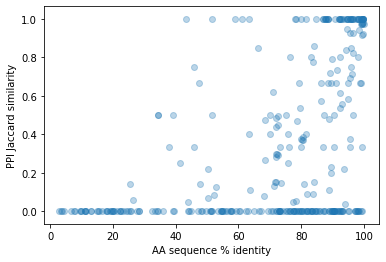

In [13]:
x = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'ppi_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PPI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../../figures/ppi_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SpearmanrResult(correlation=0.42001130703951567, pvalue=2.426029295305715e-06)


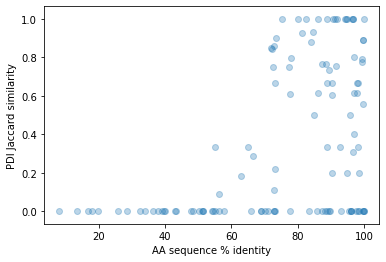

In [14]:
x = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'pdi_jaccard'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('PDI Jaccard similarity')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../../figures/pdi_jaccard_vs_aa_id.pdf',
            bbox_inches='tight')

SpearmanrResult(correlation=-0.34780169867529054, pvalue=6.301558418393862e-19)


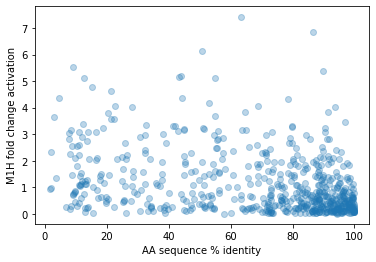

In [15]:
x = iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'aa_seq_pct_id'].values
y = iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'activation_fold_change'].values
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, alpha=0.3)
ax.set_ylabel('M1H fold change activation')
ax.set_xlabel('AA sequence % identity')
print(stats.spearmanr(x, y))
plt.savefig('../../figures/m1h_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

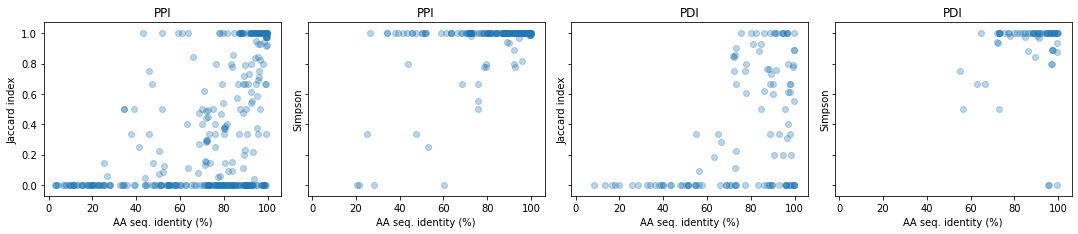

In [16]:
# Jaccard/Simpson versus similarity for PPI and PDI
def make_profile_diff_vs_seq_plot(df):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,3))
    fig.tight_layout()
    (ax1, ax2, ax3, ax4) = axs
    
    for ax in axs: ax.set_xlabel('AA seq. identity (%)')
        
    alpha=0.3
    
    ax1.scatter(df.aa_seq_pct_id, df.ppi_jaccard, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_ylabel('Jaccard index')
    ax2.scatter(df.aa_seq_pct_id, df.ppi_simpson, alpha=alpha)
    ax2.set_title('PPI')
    ax2.set_ylabel('Simpson')
    ax3.scatter(df.aa_seq_pct_id, df.pdi_jaccard, alpha=alpha)
    ax3.set_title('PDI')
    ax3.set_ylabel('Jaccard index')
    ax4.scatter(df.aa_seq_pct_id, df.pdi_simpson, alpha=alpha)
    ax4.set_title('PDI')
    ax4.set_ylabel('Simpson')

make_profile_diff_vs_seq_plot(iso_pairs)

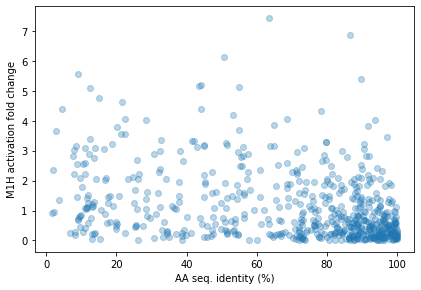

In [17]:
# Jaccard/Simpson versus similarity for M1H
fig, ax1 = plt.subplots(1, sharex=True, sharey=True)
fig.tight_layout()
alpha=0.3
ax1.scatter(iso_pairs.aa_seq_pct_id, iso_pairs.activation_fold_change, alpha=alpha)
ax1.set_xlabel('AA seq. identity (%)')
ax1.set_ylabel('M1H activation fold change')
plt.savefig('../../figures/M1H_fold_change_vs_aa_id.pdf',
            bbox_inches='tight')

In [18]:
# get isoform-specific y1h and y2h degree
deg = y1h.loc[:, y1h.columns[2:]].sum(axis=1).rename('y1h_degree')
y1h_nd = y1h[['tf', 'unique_acc']].join(deg, how='left')
y2h_nd = y2h.loc[y2h.category=='tf_isoform_ppis', :].groupby('ad_clone_acc')['ad_clone_acc'].count().rename('y2h_degree')
int_nd = y1h_nd.join(y2h_nd, how='outer', on='unique_acc')
int_nd.head()

,tf,unique_acc,y1h_degree,y2h_degree
162.0,CREB1,CREB1|1/2|02E01,0.0,1.0
0.0,CREB1,CREB1|2/2|01F12,3.0,1.0
1.0,DLX1,DLX1|1/2|07A12,9.0,NaN
174.0,DLX1,DLX1|2/2|07E09,0.0,NaN
2.0,DLX4,DLX4|1/3|11A04,3.0,1.0


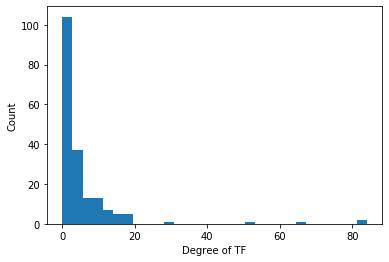

Text(0, 0.5, 'Count')

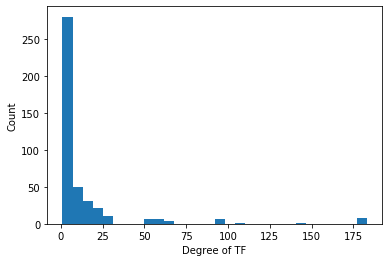

In [19]:
# plot the degree distributions
# degere of y1h
plt.hist(int_nd.y1h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')
plt.show()
plt.hist(int_nd.y2h_degree.dropna(), bins=30) 
plt.xlabel('Degree of TF')
plt.ylabel('Count')

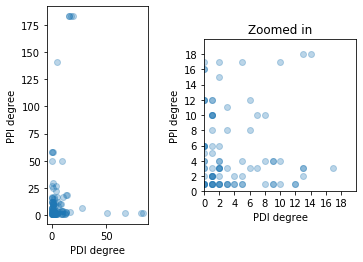

In [20]:
# compare pdi versus ppi degree
fig, (ax1, ax2) = plt.subplots(1,2)
alpha = 0.3

ax1.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax1.set_aspect('equal')
ax1.set_xlabel('PDI degree')
ax1.set_ylabel('PPI degree')

ax2.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax2.set_aspect('equal')
ax2.set_xlabel('PDI degree')
ax2.set_ylabel('PPI degree')
ax2.set_title('Zoomed in')
ax2.set_xlim(0,20)
ax2.set_xticks(range(0,20,2))
ax2.set_ylim(0,20)
ax2.set_yticks(range(0,20,2));
# ax2.set_yscale('log')
# ax2.set_xscale('log')


SpearmanrResult(correlation=-0.26507906812599813, pvalue=1.321168465578112e-05)


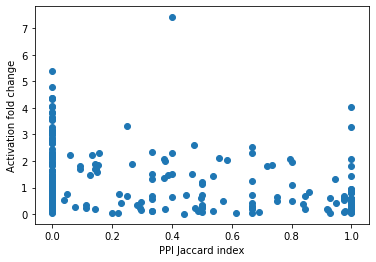

In [21]:
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
plt.xlabel('PPI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../../figures/ppi_vs_activation.pdf',
            bbox_inches='tight')

(104, 20)
SpearmanrResult(correlation=-0.2500113196982098, pvalue=0.010479425843809722)


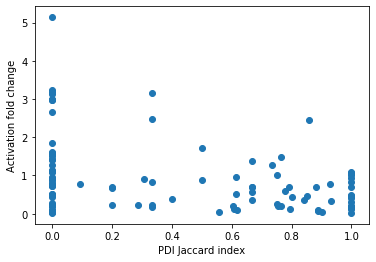

In [22]:
x = 'pdi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
plt.xlabel('PDI Jaccard index')
plt.ylabel('Activation fold change')
print(stats.spearmanr(xy[x], xy[y]))
plt.savefig('../../figures/pdi_vs_activation.pdf',
            bbox_inches='tight')

(58, 20)


SpearmanrResult(correlation=0.23670027739697486, pvalue=0.07362599017568584)

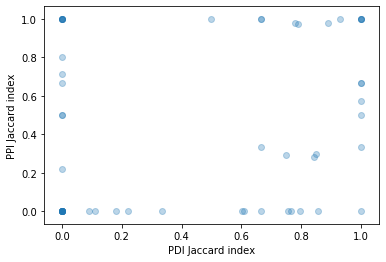

In [23]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [24]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
print(iso_pairs['ppi_n_min']>=1)
print(iso_pairs[x].notnull())

0      False
1       True
2      False
3      False
4      False
       ...  
801    False
802    False
803    False
804    False
805     True
Name: ppi_n_min, Length: 806, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
801    False
802    False
803    False
804    False
805    False
Name: pdi_jaccard, Length: 806, dtype: bool


(23, 20)


SpearmanrResult(correlation=-0.21153400770159445, pvalue=0.3325792394678654)

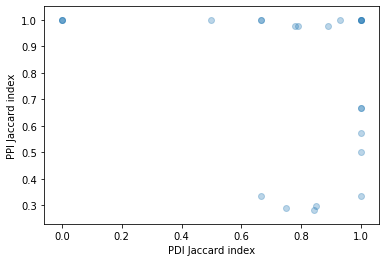

In [25]:
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull() & (iso_pairs['ppi_n_min']>=1) & (iso_pairs['pdi_n_min']>=1), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
plt.xlabel('PDI Jaccard index')
plt.ylabel('PPI Jaccard index')
stats.spearmanr(xy[x], xy[y])

In [26]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [27]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
568,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,15.0,5.0,9.0,4.0,0.333333,0.555556,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.324958,76.0
569,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,ZBTB44|1/9|12B06_ZBTB44|5/9|10H05,15.0,6.0,9.0,3.0,0.400000,0.666667,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493713,75.8
324,PATZ1,PATZ1|1/4|02C02,PATZ1|3/4|02A04,PATZ1|1/4|02C02_PATZ1|3/4|02A04,18.0,12.0,15.0,3.0,0.666667,0.800000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.239169,79.4
467,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,TCF4|5/9|07C02_TCF4|7/9|07G03,58.0,46.0,49.0,3.0,0.793103,0.938776,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.090708,89.8
726,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,ZNF451|6/8|05H11_ZNF451|7/8|06D01,8.0,1.0,4.0,3.0,0.125000,0.250000,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.485041,52.9
717,ZNF451,ZNF451|3/8|06A03,ZNF451|7/8|06D01,ZNF451|3/8|06A03_ZNF451|7/8|06D01,7.0,1.0,3.0,2.0,0.142857,0.333333,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.686811,25.3
567,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,ZBTB44|1/9|12B06_ZBTB44|3/9|10B06,15.0,7.0,9.0,2.0,0.466667,0.777778,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.525376,78.6
716,ZNF451,ZNF451|3/8|06A03,ZNF451|6/8|05H11,ZNF451|3/8|06A03_ZNF451|6/8|05H11,7.0,1.0,3.0,2.0,0.142857,0.333333,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.201770,47.6
323,PATZ1,PATZ1|1/4|02C02,PATZ1|2/4|02D04,PATZ1|1/4|02C02_PATZ1|2/4|02D04,15.0,4.0,6.0,2.0,0.266667,0.666667,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.873488,68.6
468,TCF4,TCF4|5/9|07C02,TCF4|8/9|07A05,TCF4|5/9|07C02_TCF4|8/9|07A05,46.0,33.0,35.0,2.0,0.717391,0.942857,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.825006,89.1


In [28]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['ppi_n_min'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

(142, 20)


SpearmanrResult(correlation=-0.26863098874853214, pvalue=0.0012273703760291082)

In [29]:
xy.sort_values('activation_fold_change', ascending=False).head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
47,E2F3,E2F3|2/4|10A08,E2F3|3/4|10B08,E2F3|2/4|10A08_E2F3|3/4|10B08,5.0,2.0,2.0,0.0,0.4,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.433645,63.4
301,NR4A1,NR4A1|1/5|03A04,NR4A1|2/5|03G05,NR4A1|1/5|03A04_NR4A1|2/5|03G05,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.029137,93.6
21,ATF2,ATF2|3/6|09C05,ATF2|5/6|09A05,ATF2|3/6|09C05_ATF2|5/6|09A05,3.0,0.0,1.0,1.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.012971,28.3
23,ATF2,ATF2|4/6|09B05,ATF2|5/6|09A05,ATF2|4/6|09B05_ATF2|5/6|09A05,4.0,0.0,1.0,1.0,0.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.793690,20.3
796,ZSCAN18,ZSCAN18|1/7|09F02,ZSCAN18|2/7|09A01,ZSCAN18|1/7|09F02_ZSCAN18|2/7|09A01,16.0,0.0,2.0,2.0,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.572874,21.4


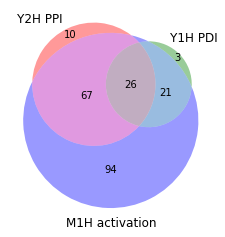

In [30]:
# overlaps

a = set(iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull(), 'tf_gene_symbol'].unique())
b = set(iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull(), 'tf_gene_symbol'].unique())
c = set(iso_pairs.loc[iso_pairs['activation_fold_change'].notnull(), 'tf_gene_symbol'].unique())
from matplotlib_venn import venn3

venn3([a, b, c],
      set_labels=['Y2H PPI', 'Y1H PDI', 'M1H activation'])
plt.savefig('../../figures/tf_gene_data_integration_venn.pdf')

In [31]:
ppi.score.value_counts()

1     2086
0     1747
NC     174
NS     131
AA     108
NA      13
Name: score, dtype: int64

In [32]:
ppi.score.isin(['0', '1']).sum() / ppi.shape[0]

0.8999765203099319

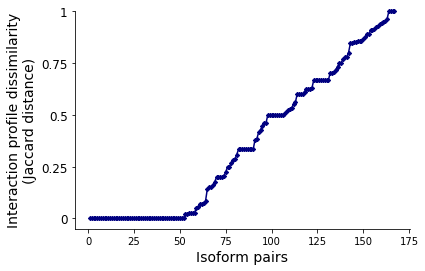

In [33]:
def remake_yang_et_al_fig_2b(values, color='navy'):
    ax.plot(range(1, values.shape[0] + 1),
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)
    

fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull() &
                       (iso_pairs['ppi_n_min'] >= 1),
                       'ppi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../../figures/remake_yang_et_al_fig4B.pdf',
            bbox_inches='tight')

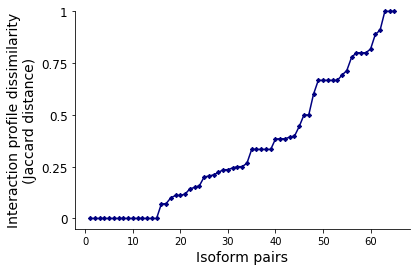

In [34]:
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull() &
                       (iso_pairs['pdi_n_min'] >= 1),
                       'pdi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../../figures/remake_yang_et_al_fig4B_PDI.pdf',
            bbox_inches='tight')

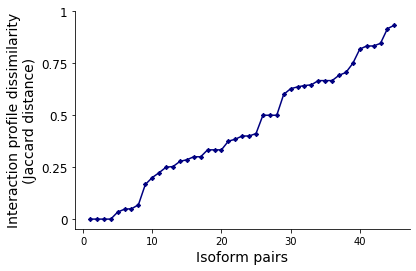

In [35]:
# combine PPI and PDI
iso_pairs['ppi_pdi_jaccard'] = ((iso_pairs['ppi_n_shared'] + iso_pairs['pdi_n_shared']) / 
                                (iso_pairs['ppi_n_tested'] + iso_pairs['pdi_n_tested']))
fig, ax = plt.subplots(1, 1)
values = iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) | (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
values = 1. - values
remake_yang_et_al_fig_2b(values)
plt.savefig('../../figures/remake_yang_et_al_fig4B_combine_PDI_PPI.pdf',
            bbox_inches='tight')

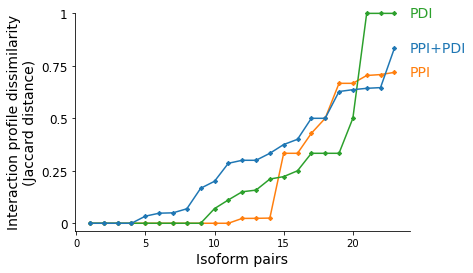

In [36]:
# all on one plot
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../../figures/remake_yang_et_al_fig4B_all_one_plot.pdf',
            bbox_inches='tight')

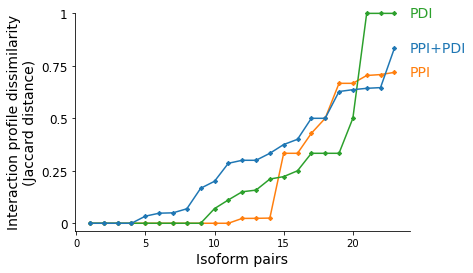

In [37]:
# all on one plot
fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                               ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                               'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) & (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b(values_ppi, color='C1')
remake_yang_et_al_fig_2b(values_pdi, color='C2')
remake_yang_et_al_fig_2b(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        values_ppi.max(), 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        values_pdi.max(), 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        values_ppi_pdi.max(), 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../../figures/remake_yang_et_al_fig4B_all_one_plot.pdf',
            bbox_inches='tight')

In [38]:
help(stats.wilcoxon)

Help on function wilcoxon in module scipy.stats.morestats:

wilcoxon(x, y=None, zero_method='wilcox', correction=False, alternative='two-sided')
    Calculate the Wilcoxon signed-rank test.
    
    The Wilcoxon signed-rank test tests the null hypothesis that two
    related paired samples come from the same distribution. In particular,
    it tests whether the distribution of the differences x - y is symmetric
    about zero. It is a non-parametric version of the paired T-test.
    
    Parameters
    ----------
    x : array_like
        Either the first set of measurements (in which case `y` is the second
        set of measurements), or the differences between two sets of
        measurements (in which case `y` is not to be specified.)  Must be
        one-dimensional.
    y : array_like, optional
        Either the second set of measurements (if `x` is the first set of
        measurements), or not specified (if `x` is the differences between
        two sets of measurements.)  Mu

In [39]:
values_ppi

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.66666667, 0.66666667, 0.        ,
       0.        , 0.02307692, 0.02459016, 0.704     , 0.0234375 ,
       0.71875   , 0.70833333, 0.33333333, 0.33333333, 0.42857143,
       0.        , 0.5       , 0.        ])

In [40]:
values_ppi_pdi

array([0.06896552, 0.5       , 0.63636364, 0.3       , 0.2       ,
       0.        , 0.16666667, 0.5       , 0.4       , 0.        ,
       0.83333333, 0.03378378, 0.04964539, 0.62758621, 0.04794521,
       0.6462585 , 0.64285714, 0.28571429, 0.3       , 0.375     ,
       0.        , 0.33333333, 0.        ])

(array([3., 5., 8., 2., 1., 1., 1., 0., 1., 1.]),
 array([-0.26666667, -0.15666667, -0.04666667,  0.06333333,  0.17333333,
         0.28333333,  0.39333333,  0.50333333,  0.61333333,  0.72333333,
         0.83333333]),
 <a list of 10 Patch objects>)

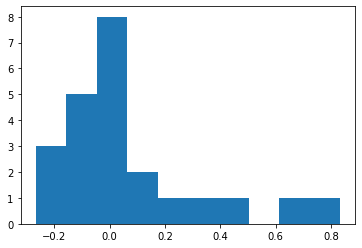

In [41]:
plt.hist(values_ppi_pdi - values_ppi)

In [42]:
stats.ttest_rel(values_ppi, values_ppi_pdi)

Ttest_relResult(statistic=-1.44205392713137, pvalue=0.16337274161581378)

In [43]:
stats.wilcoxon(values_ppi, values_ppi_pdi)

WilcoxonResult(statistic=80.5, pvalue=0.5595091741435549)

In [44]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

Ks_2sampResult(statistic=0.43478260869565216, pvalue=0.02472024578256561)

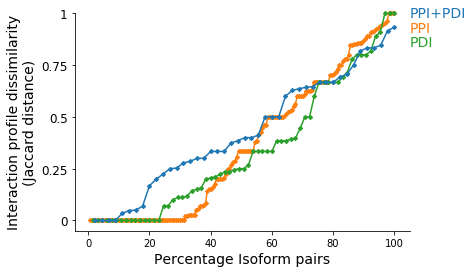

In [45]:
def remake_yang_et_al_fig_2b_pct_x(values, color='navy'):
    ax.plot(np.linspace(0, 100, values.shape[0] + 1)[1:],
            sorted(values),
            marker='D',
            markersize=3,
            color=color,
            clip_on=False)
    ax.set_xlabel('Percentage Isoform pairs', fontsize=14)
    ax.set_ylabel('Interaction profile dissimilarity\n(Jaccard distance)',
                  fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels(['{:g}'.format(t) for t in ax.get_yticks()],
                       fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], 1)


fig, ax = plt.subplots(1, 1)
values_ppi = 1 - iso_pairs.loc[iso_pairs['ppi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1)),
                       'ppi_jaccard'].values
values_pdi = 1 - iso_pairs.loc[iso_pairs['pdi_jaccard'].notnull() &
                       ((iso_pairs['pdi_n_min'] >= 1)),
                       'pdi_jaccard'].values
values_ppi_pdi = 1 - iso_pairs.loc[iso_pairs['ppi_pdi_jaccard'].notnull() &
                       ((iso_pairs['ppi_n_min'] >= 1) | (iso_pairs['pdi_n_min'] >= 1)),
                       'ppi_pdi_jaccard'].values
remake_yang_et_al_fig_2b_pct_x(values_ppi, color='C1')
remake_yang_et_al_fig_2b_pct_x(values_pdi, color='C2')
remake_yang_et_al_fig_2b_pct_x(values_ppi_pdi, color='C0')
ax.text(ax.get_xlim()[1], 
        0.93, 
        'PPI',
        va='center',
        fontsize=14,
        color='C1')
ax.text(ax.get_xlim()[1], 
        0.86, 
        'PDI',
        va='center',
        fontsize=14,
        color='C2')
ax.text(ax.get_xlim()[1], 
        1, 
        'PPI+PDI',
        va='center',
       fontsize=14,
       color='C0')
plt.savefig('../../figures/remake_yang_et_al_fig4B_all_one_plot_pct_isoforms.pdf',
            bbox_inches='tight')

In [46]:
stats.ks_2samp(values_ppi, values_ppi_pdi)

Ks_2sampResult(statistic=0.258416500332668, pvalue=0.013997968177284714)

In [47]:
stats.ks_2samp(values_pdi, values_ppi_pdi)

Ks_2sampResult(statistic=0.24102564102564103, pvalue=0.07527111331518466)

In [51]:
iso_pairs.loc[(iso_pairs['pdi_jaccard'] == 0) &
              (iso_pairs['pdi_n_min'] >= 1), :]

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id,ppi_pdi_jaccard
219,LHX9,LHX9|1/3|06C10,LHX9|2/3|06D10,LHX9|1/3|06C10_LHX9|2/3|06D10,4.0,4.0,4.0,0.0,1.0,1.0,...,4.0,0.0,1.0,1.0,0.0,0.0,4.0,0.791181,99.7,0.500000
220,LHX9,LHX9|1/3|06C10,LHX9|3/3|07A01,LHX9|1/3|06C10_LHX9|3/3|07A01,4.0,4.0,4.0,0.0,1.0,1.0,...,7.0,0.0,1.0,1.0,0.0,0.0,7.0,0.102355,96.0,0.363636
385,RORC,RORC|3/6|12D07,RORC|4/6|05B09,RORC|3/6|12D07_RORC|4/6|05B09,1.0,1.0,1.0,0.0,1.0,1.0,...,5.0,0.0,1.0,1.0,0.0,0.0,5.0,0.509874,95.4,0.166667
